# CS 342 Neural Nets: Final Project

Authors: Ryan Gahagan (rg32643) and Dustan Helm (dbh878)

### Overview

In this project, we will create a neural network that will hopefully be able to predict the quality of various wines given their chemical compositions.

This project's data set and idea are based off another paper, cited here:

  "P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis.
  
  Modeling wine preferences by data mining from physicochemical properties.
  
  In Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 0167-9236."

We plan to make a feed-forward network to process this data, as well as some experiments to test and analyze our network.

## Data Pre-processing

First, we have to take the data set and process it into a format that Python can use.

In [1]:
# Run this block to load important libraries and set things up
import torch
from torch import nn
import numpy as np
import scipy.signal

%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

from torch.utils.data.sampler import SubsetRandomSampler

from tqdm.notebook import tqdm
import itertools

In [2]:
# Load in dataset files
white_file = open("winequality-white-nolabels.csv")
wine_quality_white = np.loadtxt(white_file, delimiter=";")
red_file = open("winequality-red-nolabels.csv")
wine_quality_red = np.loadtxt(red_file, delimiter=";")

In [3]:
# Create suitable data_arrays
num_samples_white = wine_quality_white.shape[0]
num_samples_red = wine_quality_red.shape[0]
num_samples_total = num_samples_white + num_samples_red

# Combine white and red wine datasets into one np array
wine_quality_combined_whitered = np.append(wine_quality_white, wine_quality_red, axis=0)

print(f"wine_quality_combined_whitered.shape = {wine_quality_combined_whitered.shape}")

assert wine_quality_combined_whitered.shape[0] == num_samples_total

# Rename
data_array = wine_quality_combined_whitered
data_array_white = wine_quality_white
data_array_red = wine_quality_red

wine_quality_combined_whitered.shape = (6497, 12)


Now we've loaded our datasets into lists. `data_array_red` is an `np.array` whose shape is `(1599,12)` and `data_array_white` is likewise an array of shape `(4898,12)`. `data_array` is simply those two arrays concatenated into an array of shape `(6497,12)`.

Note that these 12 columns represent both features and labels.

The columns, in order, are:
- fixed acidity
- volatile acidity
- citric acid
- residual sugar
- chlorides
- free sulfur dioxide
- total sulfur dioxide
- density
- pH
- sulphates
- alcohol
- quality (integer in \[0,10\])
where quality is our label.

## Data Breakdown

Before we process the data into a more pytorch-friendly form, here's a breakdown of the range and averages of each dataset's 11 features. 

You can run the cell directly below this one to show the data.

In [4]:
start_ends = []
start_ends_white = []
start_ends_red = []

avgs = []
avgs_white = []
avgs_red = []

datasets = [data_array, data_array_white, data_array_red]
averages = [avgs, avgs_white, avgs_red]
start_ends_list = [start_ends, start_ends_white, start_ends_red]

for i in range(3):
    data_arr = datasets[i]
    avgs_arr = averages[i]
    start_ends_arr = start_ends_list[i]
    print(f"Min, Max, Average Information for Dataset #{i+1}/3:")
    for j in range(11):
        start = np.amin(data_arr[:,j])
        end = np.amax(data_arr[:,j])
        avg = np.average(data_arr[:,j])
        start_ends_arr.append((start, end))
        avgs_arr.append(avg)
        print(f"Feature #{j+1}/11: (Min, Max) = {start_ends_arr[j]}, avg = {avgs_arr[j]}")


Min, Max, Average Information for Dataset #1/3:
Feature #1/11: (Min, Max) = (3.8, 15.9), avg = 7.215307064799138
Feature #2/11: (Min, Max) = (0.08, 1.58), avg = 0.33966599969216565
Feature #3/11: (Min, Max) = (0.0, 1.66), avg = 0.3186332153301524
Feature #4/11: (Min, Max) = (0.6, 65.8), avg = 5.443235339387409
Feature #5/11: (Min, Max) = (0.009, 0.611), avg = 0.05603386178236109
Feature #6/11: (Min, Max) = (1.0, 289.0), avg = 30.525319378174544
Feature #7/11: (Min, Max) = (6.0, 440.0), avg = 115.7445744189626
Feature #8/11: (Min, Max) = (0.98711, 1.03898), avg = 0.9946966338309989
Feature #9/11: (Min, Max) = (2.72, 4.01), avg = 3.2185008465445586
Feature #10/11: (Min, Max) = (0.22, 2.0), avg = 0.5312682776666153
Feature #11/11: (Min, Max) = (8.0, 14.9), avg = 10.491800831152778
Min, Max, Average Information for Dataset #2/3:
Feature #1/11: (Min, Max) = (3.8, 14.2), avg = 6.854787668436097
Feature #2/11: (Min, Max) = (0.08, 1.1), avg = 0.27824111882400976
Feature #3/11: (Min, Max) = (0.

In [5]:
# Split data array into features and label arrays
# Inputs: 
#     data_array: Data array to be split into features and labels
# Outputs:
#     data_array_feats: Features for data_array
#     data_array_labels: Labels for data_array
def split_features_labels(data_array):
    assert isinstance(data_array, np.ndarray)
    #assert data_array.shape[1] == 12
    
    data_array_feats = data_array[:,:-1] # first 11 columns
    data_array_labels = data_array[:,-1] # last column

    #assert data_array_feats.shape[1] == 11
    assert data_array_feats.shape[0] == data_array_labels.shape[0]
    
    return data_array_feats, data_array_labels

In [6]:
# Split data array into training and testing sets based on the provided train_proportion parameter
# Inputs: 
#     data_array: Dataset to split for training and testing
#     train_proportion: Proportion of datapoints to be kept as training data
# Outputs:
#     train_set: Training set containing a proportion of the datapoints contained in data_array specified by input parameter.
#     test_set: Testing set containing held-back datapoints to test the trained model
def train_test_split(data_array, train_proportion):
    assert isinstance(data_array, np.ndarray)
    #assert data_array.shape[1] == 12
    
    num_samples = data_array.shape[0]
    
    feats, labels = split_features_labels(data_array)
    data_set = torch.utils.data.TensorDataset(torch.tensor(feats), torch.tensor(labels).long())
    
    train_size = int(train_proportion*num_samples)
    test_size = num_samples - train_size
    
    train_set, test_set = torch.utils.data.random_split(data_set, [train_size, test_size])
    
    assert abs(len(train_set) / len(data_array) - train_proportion) < 0.01
    assert abs(len(test_set) / len(data_array)  - (1 - train_proportion)) < 0.01
    
    return train_set, test_set

In [7]:
# Perform the actual split on all of our datasets into training and testing
train_proportion = 0.8
train_proportion_white = 0.8
train_proportion_red = 0.8

train_set, test_set = train_test_split(data_array, train_proportion)
train_set_white, test_set_white = train_test_split(data_array_white, train_proportion_white)
train_set_red, test_set_red = train_test_split(data_array_red, train_proportion_red)

In [8]:
# Split training set into true training and validation data based on the input proportion
# Inputs:
#     ntotal: Total number of datapoints in the original training set to be used to determine the split
#     train_proportion: Proportion of the training set examples which should not be placed into the validation set
# Outputs:
#     train_ix: Indices for training examples
#     val_ix: Indices for validation examples

def train_val_split_ix(ntotal, train_proportion):
    ntrain = int(train_proportion*ntotal)
    nval = ntotal - ntrain
    
    val_ix = np.random.choice(range(ntotal), size=nval, replace=False)
    train_ix = list(set(range(ntotal)) - set(val_ix))
    
    assert abs(len(train_ix) / ntotal - train_proportion) < 0.01
    assert abs(len(val_ix) / ntotal - (1 - train_proportion)) < 0.01
    
    return (train_ix, val_ix)

In [9]:
# Perform the training/validation split and then confirm array lengths
train_proportion2 = 0.9
train_proportion_white2 = 0.9
train_proportion_red2 = 0.9

train_ix, val_ix = train_val_split_ix(len(train_set), train_proportion2)
train_white_ix, val_white_ix = train_val_split_ix(len(train_set_white), train_proportion_white2)
train_red_ix, val_red_ix = train_val_split_ix(len(train_set_red), train_proportion_red2)

print(f"(len(train_ix), len(val_ix)) = ({len(train_ix)}, {len(val_ix)})")
print(f"(len(train_white_ix), len(val_white_ix)) = ({len(train_white_ix)}, {len(val_white_ix)})")
print(f"(len(train_red_ix), len(val_red_ix)) = ({len(train_red_ix)}, {len(val_red_ix)})")

assert len(train_ix) + len(val_ix) == len(train_set)
assert len(train_white_ix) + len(val_white_ix) == len(train_set_white)
assert len(train_red_ix) + len(val_red_ix) == len(train_set_red)

(len(train_ix), len(val_ix)) = (4677, 520)
(len(train_white_ix), len(val_white_ix)) = (3526, 392)
(len(train_red_ix), len(val_red_ix)) = (1151, 128)


In [10]:
# Set up data samplers for use in DataLoader objects
# Inputs: 
#     datalist_ix: Tuple of index lists used to determine each loader's data
# Outputs:
#     result: Tuple of SubsetRandomSamplers representing each index list object in datalist_ix
def setup_samplers(datalist_ix):
    result = ()
    for data_ix in datalist_ix:
        result += (SubsetRandomSampler(data_ix),)
    return result

In [11]:
# Set up a tuple of Data Loaders based on provided datasets, samplers, and batch_size
# Inputs:
#     datalist: List of datasets to give to the DataLoaders
#     samplers: List of samplers to use in the DataLoaders
#     batch_size: DataLoader batch size (Currently uses the same batch_size for every dataset passed)
# Outputs:
#     Tuple of DataLoader objects len(datalist) size long 
def setup_data_loaders(datalist, samplers, batch_size):
    assert len(datalist) == len(samplers)
    
    result = ()
    for i in range(len(datalist)):
        data = datalist[i]
        sampler = samplers[i]
        result += (torch.utils.data.DataLoader(data, batch_size, sampler=sampler),)
    return result

#TODO: It may be useful to have different batch_size values for training, validation, and testing. 
# In that event, batch_size should be replaced with a touple of batch_size values and the following should be added to the loop:
# batch_size = batch_sizes[i]

Now that we've declared methods to do various helper tasks, we're going to actually break our data into useful information.

The three sets of data (red, white, and combined) will be each partitioned into a training set, a validation set, and a testing set (whose sizes will be proportional to the variables declared above). We will then create `DataLoader` objects for each of these partitions so that we can iterate over them in our training section.

Note here that we also declare batch sizes to determine how many pieces of information are trained on at a time.

In [12]:
# Set up samplers and DataLoaders for all three datasets (Combined, White, Red)
batch_size = 100
batch_size_white = 100
batch_size_red = 100

#COMBINED DATASET
sampler_input = (train_ix, val_ix)
train_sampler, val_sampler = setup_samplers(sampler_input)

datalist = (train_set, train_set, test_set)
samplers = (train_sampler, val_sampler, None)
train_loader, val_loader, test_loader = setup_data_loaders(datalist, samplers, batch_size)

#JUST WHITE
sampler_input_white = (train_white_ix, val_white_ix)
train_sampler_white, val_sampler_white = setup_samplers(sampler_input_white)

datalist_white = (train_set_white, train_set_white, test_set_white)
samplers_white = (train_sampler_white, val_sampler_white, None)
train_loader_white, val_loader_white, test_loader_white = setup_data_loaders(datalist_white, samplers_white, batch_size_white)

#JUST RED
sampler_input_red = (train_red_ix, val_red_ix)
train_sampler_red, val_sampler_red = setup_samplers(sampler_input_red)

datalist_red = (train_set_red, train_set_red, test_set_red)
samplers_red = (train_sampler_red, val_sampler_red, None)
train_loader_red, val_loader_red, test_loader_red = setup_data_loaders(datalist_red, samplers_red, batch_size_red)

In [13]:
# Re-splits the data into new random chunks to help reduce noise
#
# Inputs: data_arrays for combined data set, white wine dataset, and red dataset to generate loaders from
# Outputs:
#    A list [full, white, red] of loader tuples (train, val, test)
def get_random_loaders(data_array, data_array_white, data_array_red):
    batch_size = 100
    batch_size_white = 100
    batch_size_red = 100
    
    # Get train/test sets
    train_set, test_set = train_test_split(data_array, train_proportion)
    train_set_white, test_set_white = train_test_split(data_array_white, train_proportion_white)
    train_set_red, test_set_red = train_test_split(data_array_red, train_proportion_red)
    
    # Get train/val indices
    train_ix, val_ix = train_val_split_ix(len(train_set), train_proportion2)
    train_white_ix, val_white_ix = train_val_split_ix(len(train_set_white), train_proportion_white2)
    train_red_ix, val_red_ix = train_val_split_ix(len(train_set_red), train_proportion_red2)
    
    #COMBINED DATASET
    sampler_input = (train_ix, val_ix)
    train_sampler, val_sampler = setup_samplers(sampler_input)

    datalist = (train_set, train_set, test_set)
    samplers = (train_sampler, val_sampler, None)
    train_loader, val_loader, test_loader = setup_data_loaders(datalist, samplers, batch_size)

    #JUST WHITE
    sampler_input_white = (train_white_ix, val_white_ix)
    train_sampler_white, val_sampler_white = setup_samplers(sampler_input_white)

    datalist_white = (train_set_white, train_set_white, test_set_white)
    samplers_white = (train_sampler_white, val_sampler_white, None)
    train_loader_white, val_loader_white, test_loader_white = setup_data_loaders(datalist_white, samplers_white, batch_size_white)

    #JUST RED
    sampler_input_red = (train_red_ix, val_red_ix)
    train_sampler_red, val_sampler_red = setup_samplers(sampler_input_red)

    datalist_red = (train_set_red, train_set_red, test_set_red)
    samplers_red = (train_sampler_red, val_sampler_red, None)
    train_loader_red, val_loader_red, test_loader_red = setup_data_loaders(datalist_red, samplers_red, batch_size_red)
    
    return [(train_loader, val_loader, test_loader), \
           (train_loader_white, val_loader_white, test_loader_white), \
           (train_loader_red, val_loader_red, test_loader_red)]

## Training

With our data processed and ready to be used, now we will write some functions to train and test a network.

In [14]:
# Train the provided model with data gathered from train_loader, the given criterion, and the given optimizer.
# Additionally perform validation checks with data from val_loader.
# Inputs:
#     model: Neural network to train
#     train_loader: DataLoader which provides training data to the model 
#     val_loader: DataLoader which provides validation data to the model
#     criterion: Loss Function which trains the model
#     optimizer: Optimization algorithm to improve loss during training 
#     nepoch: Number of epochs to train for (Defaults to 100)
# Outputs:
#     Prints the Training and Validation loss at each epoch
def train_network(model, train_loader, val_loader, criterion, optimizer, nepoch=100,silent=True):
    try:
        cur_range = None
        if silent:
            cur_range = range(nepoch)
        else:
            cur_range = tqdm(range(nepoch))

        for epoch in cur_range:
            # Train over each epoch with a progress bar (tqdm)
            if not silent: 
                print('EPOCH %d'%epoch)
            
            total_loss = 0
            count = 0
            for inputs, labels in train_loader:
                # For each train input: 
                optimizer.zero_grad()
                
                # Forward propagate inputs
                outputs = model.forward(inputs)
                
                # Compute loss and learn
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                # Add current loss to batch average
                total_loss += loss.item()
                count += 1
            
            # Show Training loss for current epoch over the train_loader data
            if not silent:
                print('{:>12s} {:>7.5f}'.format('Train loss:', total_loss/count))
            
            with torch.no_grad():
                # Perform Validation checks on the newly trained model
                total_loss = 0
                count = 0
                for inputs, labels in val_loader:
                    # Forward propagate inputs
                    outputs = model.forward(inputs)
                    
                    # Compute Loss
                    loss = criterion(outputs, labels)
                    
                    # Add current loss to batch average
                    total_loss += loss.item()
                    count += 1
                    
                # Show Validation loss for current epoch over the val_loader data
                if not silent:
                    print('{:>12s} {:>7.5f}'.format('Val loss:', total_loss/count))
                    print()
    except KeyboardInterrupt as e:
        print('Exiting from training early')
        raise e
    return

In [15]:
# Test the provided model with data from test_loader
# Inputs:
#     model: Model to test using unseen data
#     test_loader: DataLoader to provide held-back testing data to trained model
#     mode: String used at front of each loss printout
# Outputs:
#     acc: Top-1 accuracy of the model on the testing data in percent
#     true: Array of actual labels
#     pred: Array of model-predicted labels
def test_network(model, test_loader, mode="test_network", silent=True):
    correct = 0
    total = 0
    true, pred = [], []
    with torch.no_grad():
        
        for inputs, labels  in test_loader:
            # Forward propagate testing data
            outputs = model.forward(inputs)
            
            # Get the prediction for inputs
            vals, predicted = torch.max(outputs, dim=1) 
            
            # Tally results 
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            true.append(labels)
            pred.append(predicted)
    
    # Compute and print final accuracy, then format outputs
    acc = (100 * correct / total)
    if not silent:
        print('%s accuracy: %0.3f' % (mode, acc))
    true = np.concatenate(true)
    pred = np.concatenate(pred)
    return acc, true, pred

In [16]:
# Single method to wrap all of training and testing
#
# Inputs:
#   Positional:
#     model: the model to train/test (should be newly initialized)
#     train_loader: DataLoader for training set
#     val_loader: DataLoader for validation set
#     test_loader: DataLoader for testing set
#     criterion: loss function (e.g. CrossEntropyLoss)
#     optimizer: optimizing function (e.g. Adam)
#   kwargs (keyword):
#     nepoch: number of epochs, defaults to 100
#     mode: string to print during test, defaults to "Model"
#     train_silent: boolean to silence training, defaults to True
#     test_silent: boolean to silence testing, defaults to True
# Outputs:
#     acc: accuracy of testing, in range (0, 100)
#     true: list of true labels
#     pred: list of predicted labels
def train_and_test(model, train_loader, val_loader, test_loader, criterion, \
                   optimizer, **kwargs):
    # Get keyword args, and default missing
    nepoch = kwargs.get("nepoch", 100)
    mode = kwargs.get("mode", "Model")
    train_silent = kwargs.get("train_silent", True)
    test_silent = kwargs.get("test_silent", True)
    try:
        train_network(model, train_loader, val_loader, criterion, optimizer, nepoch, train_silent)
    except KeyboardInterrupt as e:
        print("train_and_test: Keyboard Interrupt detected, raising an exception")
        raise e
    model.eval()
    acc, true, pred = test_network(model, test_loader, mode, test_silent)
    return acc, true, pred

## Model

With our training and testing functionality equipped, now we will actually decide how to build our model.

Note here that there will be a heavy focus on making the model flexible so that we can tune hyperparameters or test new input varieties.

In [17]:
class WineQualityModel(torch.nn.Module):
    # Constructor for a WineQualityModel
    # Inputs:
    #     layers: a tuple of layers that you want in the model
    #       note that the output shape must be of length 10
    def __init__(self, layers):
        super().__init__()

        # NOTE: this gives the construction tons of flexibility
        # but also leaves plenty of room for dimensionality errors
        self.layers = torch.nn.Sequential(*layers)
        
    def forward(self, x):
        return self.layers.forward(x.float())

In [19]:
model = WineQualityModel((
    torch.nn.Linear(11, 81),
    torch.nn.LeakyReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(81, 11)
))

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_and_test(model, train_loader, val_loader, test_loader, criterion, \
               optimizer, mode="Combined Model", test_silent=False)

model_white = WineQualityModel((
    torch.nn.Linear(11, 81),
    torch.nn.LeakyReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(81, 11)
))

optimizer_white = torch.optim.Adam(model_white.parameters(), lr=1e-3)
train_and_test(model_white, train_loader_white, val_loader_white, test_loader_white, \
               criterion, optimizer_white, mode="White Model", test_silent=False)

model_red = WineQualityModel((
    torch.nn.Linear(11, 81),
    torch.nn.LeakyReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(81, 11)
))

optimizer_red = torch.optim.Adam(model_red.parameters(), lr=1e-3)
_, _, _ = train_and_test(model_red, train_loader_red, val_loader_red, test_loader_red, \
                         criterion, optimizer_red, mode="Red Model", test_silent=False)

Combined Model accuracy: 53.154
White Model accuracy: 50.408
Red Model accuracy: 57.812


## Hypertuning

Now that we have the ability to initialize and train a model, we're going to try hypertuning some of the parameters. Specifically we want to try tuning the number of layers and the hidden size of each of those layers. 

In [18]:
# Given a set of layers, creates a model that fits that specification
# then trains and tests it, all in one method. There are actually three
# models of identical specification constructed and trained separately,
# and their results are likewise returned piecewise.
#
# Inputs:
#     layers: a tuple of all the layers you want in your model
# Outputs:
#     true_lists: a tuple of lists of all the actual labels per dataset
#                 in the order (full, white, red)
#     pred_lists: a tuple of lists of model predictions per model/dataset
#                 in the order (full, white, red)
def create_and_report_model(layers, nepoch=250):
    assert len(layers) > 0
    
    # Check that you start and end with Linears
    assert isinstance(layers[0], torch.nn.Linear)
    assert isinstance(layers[-1], torch.nn.Linear)
    
    # Check that first layer takes in 11
    # we may need to remove this during computational experiments
    assert layers[0].weight.shape[1] == 11
    
    # Check that final layer outputs 11
    assert layers[-1].weight.shape[0] == 11
    
    loaders = get_random_loaders(data_array, data_array_white, data_array_red)

    true_lists = []
    pred_lists = []
    for i in range(3):
        criterion = torch.nn.CrossEntropyLoss()
        cur_loaders = loaders[i]
        cur_model = WineQualityModel(layers)
        optimizer = torch.optim.Adam(cur_model.parameters(), lr=1e-3)
        try:
            acc, true, pred = train_and_test(cur_model, *cur_loaders, criterion, \
                                         optimizer, nepoch=nepoch, mode=f"Model {i}")
        except KeyboardInterrupt as e:
            print("create_and_report_model. Training ended early. Raising an exception")
            raise e
        
        true_lists.append(true)
        pred_lists.append(pred)

    return true_lists, pred_lists

In [19]:
# Computes the accuracy of a prediction list compared to a true list
# Measures two accuracies: exact accuracy, and tolerance 1 accuracy
#
# Inputs:
#     true: a list of actual labels
#     pred: a list of predicted labels
# Outputs:
#     exact_acc: percentage (in range (0,100)) of exact matches
#     t1_acc: percentage (range of (0,100)) of 1-tolerance matches
def compute_model_accuracies(true, pred):
    assert len(true) == len(pred)
    
    num_exact = 0
    num_1_tolerant = 0
    
    for i in range(len(true)):
        t = true[i]
        p = pred[i]
        
        if t == p:
            # Exact match
            num_exact += 1

        if abs(t - p) <= 1:
            # Within one (e.g. 6,7,8 are all within 1 of 7)
            num_1_tolerant += 1
    
    exact_acc = num_exact / len(true)
    t1_acc = num_1_tolerant / len(true)
    return 100 * exact_acc, 100 * t1_acc

In [20]:
# Example of how we might train everything
true_lists, pred_lists = create_and_report_model((
    torch.nn.Linear(11,49,bias=True),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(49,11,bias=False),
))
print("Full accuracies (exact, T1):")
print(compute_model_accuracies(true_lists[0], pred_lists[0]))
print("\nWhite accuracy:")
print(compute_model_accuracies(true_lists[1], pred_lists[1]))
print("\nRed accuracy:")
print(compute_model_accuracies(true_lists[2], pred_lists[2]))

Full accuracies (exact, T1):
(52.84615384615384, 94.84615384615384)

White accuracy:
(55.61224489795919, 96.0204081632653)

Red accuracy:
(64.0625, 95.3125)


In [20]:
# Big ol' wrapper over the whole tuning test
# Just pass in the layers you want to test, and it'll spit out
# the accuracy of that tuning on all three datasets
#
# Inputs:
#     layers: layers of your model (tuple)
# Ouputs:
#     accuracies: list of 3 tuples, where each tuple holds the accuracies
#                 i.e. (exact_acc, t1_acc) as percentage from 0 to 100
def test_tuning(layers, nepoch=250):
    num_noise_tests = 3
    accuracies = [[0, 0], [0, 0], [0,0]]
    for i in range(num_noise_tests):
        try:
            true_lists, pred_lists = create_and_report_model(layers, nepoch)
        except KeyboardInterrupt as e:
            print("test_tuning: Training ended early due to keyboard interrupt. Raising an exception")
            raise e

        for j in range(3):
            cur_accs = compute_model_accuracies(true_lists[j], pred_lists[j])
            accuracies[j][0] += cur_accs[0]
            accuracies[j][1] += cur_accs[1]
            
    for i in range(len(accuracies)):
        accuracies[i][0] /= num_noise_tests
        accuracies[i][1] /= num_noise_tests
        accuracies[i] = tuple(accuracies[i])

    return accuracies

# The previous cell can now be written simply as:
# accs = test_tuning((... layers))
# You can use these accuracy tuples to print columns in a csv or smth

In [21]:
# Turns the accuracy list into a usable string
# TODO: make thsi return your string in a way you actually
# can use in a csv or whatever we want
#
# Inputs:
#     accs: a list of tuple pairs representing the accuracies
# Outputs:
#     acc_str: a usable string representation of the accuracies
#              cur format is [(full_exact, full_t1),(w_e,w_t),(r_e,r_t)]
def get_accuracies_string(accs):
    assert len(accs) == 3
    assert len(accs[0]) == 2
    assert len(accs[1]) == 2
    assert len(accs[2]) == 2
    
    acc_str = "["
    for i in range(3):
        acc_str += ("(%0.2f,%0.2f)" % (accs[i][0], accs[i][1]))
        if i != 2:
            acc_str += ","
    return acc_str

Now we've got plenty of methods to reduce the complexity of our hypertuning loops, so all that's left is to actually write then in a readable way!

In [23]:
# Here's a boring naive single layer test
accs = test_tuning(
    (torch.nn.Linear(11, 11, bias=False),) # super important comma
)
print("Naive accuracies [(full_exact, full_t1), (white_exact, white_t1), (red_exact, red_t1)]:")
print(get_accuracies_string(accs))

Naive accuracies [(full_exact, full_t1), (white_exact, white_t1), (red_exact, red_t1)]:
[(52.92,94.15),(52.45,94.18),(52.50,95.62)


In [24]:
accs = test_tuning((
    torch.nn.Linear(11, 40, bias=True),
    torch.nn.Dropout(0.3),
    torch.nn.ReLU(),
    torch.nn.Linear(40, 11, bias=False),
))
print(get_accuracies_string(accs))

accs = test_tuning((
    torch.nn.Linear(11, 40, bias=True),
    torch.nn.Dropout(0.3),
    torch.nn.BatchNorm1d(40),
    torch.nn.ReLU(),
    torch.nn.Linear(40, 11, bias=False),
))
print(get_accuracies_string(accs))

[(54.31,94.15),(53.27,95.00),(55.62,96.56)
[(55.23,95.23),(55.10,95.41),(55.62,95.94)


In [22]:
# Now let's get loopy

# Builds a generic Linear->ReLU->Dropout->... layer chain
#
# Inputs:
#     hiddens: a list of all hidden sizes in order (not empty)
#     input_features (default = 11): integer number of input features to give the model
# Outputs:
#     layers: the generic layers
def build_generic_layers(hiddens, input_features=11):
    full = [input_features] + hiddens + [11]
    stop = len(full) - 1
    layers = tuple()
    for i in range(stop):
        if i != (stop - 1):
            layers += (
                torch.nn.Linear(full[i], full[i+1], bias=True),
                torch.nn.Dropout(0.25),
                torch.nn.BatchNorm1d(full[i+1]),
                torch.nn.ReLU(),
            )
        else:
            layers += (
                torch.nn.Linear(full[i], full[i+1], bias=False),
            )
    return layers

In [23]:
# Tests a generic n-layer network, given the number of hidden
# layers and the potential sizes of every hidden layer
#
# Inputs:
#     n: number of hidden layers (> 0)
#     hidden_sizes: tuple of lists of hidden sizes (one list per layer)
#       ex: ([1,2,3], [5,6,7]) would be two layers with three sizes each
#     silent (default = True): Determines whether debug printouts will run
#     input_features (default = 11): Number of input features to give the generic model
# Outputs: None
def test_generic_n_layer(n, hidden_sizes, silent=True, input_features=11):
    assert n > 0
    assert len(hidden_sizes) == n
    
    # Use cartesian product to cleverly hide recursive loops
    # built with a generator too, so it doesn't eat RAM
    accuracies = []
    cool_product = itertools.product(*hidden_sizes)
    for pattern in cool_product:
        layers = build_generic_layers(list(pattern), input_features)
        try:
            accs = test_tuning(layers)
        except KeyboardInterrupt as e:
            print("test_generic_n_layer: Training ended early due to Keyboard Interrupt. Raising an exception.")
            raise e
        if not silent:
            print("Tested with hidden sizes", pattern)
            print(get_accuracies_string(accs))
            print()
        accuracies.append(accs)
    return accuracies

In [27]:
# Here's how you can use all that code!
# This line tests a single hidden layer with the following possible dims:
#   11 -> 5  -> 11
#   11 -> 10 -> 11
#   11 -> 15 -> 11
test_generic_n_layer(1, ([5, 10, 15],))

# This line will test 2 hidden layers with the following combinations:
#   11 -> 15 -> 5  -> 11
#   11 -> 15 -> 10 -> 11
#   11 -> 20 -> 5  -> 11
#   11 -> 20 -> 10 -> 11
test_generic_n_layer(2, ([15, 20], [5, 10],))

[[(52.46153846153846, 93.92307692307692),
  (55.10204081632652, 96.12244897959184),
  (58.4375, 96.25)],
 [(53.92307692307692, 93.15384615384616),
  (54.285714285714285, 95.61224489795919),
  (55.625, 95.0)],
 [(52.53846153846153, 93.76923076923077),
  (54.18367346938775, 95.81632653061224),
  (53.43750000000001, 96.25)],
 [(48.38461538461539, 90.07692307692308),
  (55.714285714285715, 95.81632653061224),
  (56.25, 95.9375)]]

In [43]:
print("Noise test:")
accs = test_tuning(
    build_generic_layers([85, 95, 105, 115, 115, 105, 95, 45]),
    1000
)
print(f"Test 1: {get_accuracies_string(accs)}")
accs = test_tuning(
    build_generic_layers([85, 95, 105, 115, 115, 105, 95, 45]),
    1000
)
print(f"Test 2: {get_accuracies_string(accs)}")
accs = test_tuning(
    build_generic_layers([85, 95, 105, 115, 115, 105, 95, 45]),
    1000
)
print(f"Test 3: {get_accuracies_string(accs)}")
accs = test_tuning(
    build_generic_layers([85, 95, 105, 115, 115, 105, 95, 45]),
    1000
)
print(f"Test 4: {get_accuracies_string(accs)}")
accs = test_tuning(
    build_generic_layers([85, 95, 105, 115, 115, 105, 95, 45]),
    1000
)
print(f"Test 5: {get_accuracies_string(accs)}")

Noise test:
Test 1: [(63.87,94.56),(73.23,95.99),(66.15,94.58)
Test 2: [(63.31,94.92),(71.19,95.34),(70.83,96.77)
Test 3: [(63.74,94.33),(74.08,96.26),(70.21,95.62)
Test 4: [(63.28,94.21),(74.18,96.09),(69.06,95.10)
Test 5: [(64.87,94.79),(73.64,95.37),(72.29,96.04)


In [29]:
accs = test_tuning(
    build_generic_layers([85,95]),
    1000
)
print(get_accuracies_string(accs))

[(55.79,92.69),(62.96,93.88),(61.88,93.65)


In [ ]:
accs = test_tuning(
    build_generic_layers([85, 95, 105, 115, 115, 105, 95, 45]),
    2000
)
accs = test_tuning(
    build_generic_layers([85, 95, 105, 115, 115, 105, 95, 45]),
    2000
)

In [24]:
# Helper method to surround a string with quotes
#
# Inputs:
#     tuple_string: a string you want to surround with quotes
# Outputs:
#     result: tuple string with quotes on either side, e.g. "\"test\""
def reformat_tuple_string(tuple_string):
    assert isinstance(tuple_string, str)
    result = "\"" + tuple_string + "\""
    return result

#"(5, 10, 15)"

In [25]:
# Save a given array to a csv file
# Inputs:
#     name: string File name (not including extension)
#     data: 2_D array_like that is ready to be saved as-is 
#     delimiter: character or string used to separate data's elements
# Outputs:
#     Saves a file "{name}.csv"
def save_as_csv(name, data, delimiter):
    
    assert isinstance(name, str)
    assert isinstance(delimiter, str)
    data = np.array(data)
    np.savetxt(f"{name}.csv", data, delimiter=str(delimiter), fmt="%s")
    
#save_as_csv("test_formatting", [reformat_tuple_string("(5, 10, 15)")], ";")

In [26]:
# Inputs:
#     accuracies: list of lists of tuples. 
#         Each index i contains 2 measure of accuracy for 3 models in the form [(acc1, acc2), ..., (acc1, acc2)]
#     hidden_sizes: tuple of lists of hidden sizes 
#     range_flag (default = True): 
#         Indicator of whether the data includes multiple models of different numbers of layers or just combinations
#         of hidden state sizes for a model of one specific number of layers. 
# Outputs:
#     accuracies_formatted:
#         2-D array where each row represents the results for a particular combination of hidden sizes
#         There should be 6 columns, the first 3 of which represent exact accuracy and the latter 3 of which represent
#         accuracy with a tolerance of 1 rating point (i.e. adjacent classification in the quality scale).  
def format_accuracies(accuracies, hidden_sizes, range_flag=False):
    print(f"format_accuracies: len(accuracies) = {len(accuracies)}, len(hidden_sizes) = {len(hidden_sizes)}")
    print(f"format_accuracies: accuracies = {accuracies}")

    accuracies_formatted = []        
    accuracies_temp = []
    
    #Determines if the loop runs once or once per hidden_sizes combination per model in [1, n]
    range_flag_switch = len(hidden_sizes) 
    if not range_flag:
        range_flag_switch = 1
    print(f"format_accuracies: range_flag_switch = {range_flag_switch}")
    
   
    for n in range(range_flag_switch):
        hidden_sizes_cur = hidden_sizes[:n+1] if range_flag else hidden_sizes
        cartesian_product = itertools.product(*hidden_sizes_cur)
        idx = 0
        for combination in cartesian_product:
            accuracy_cur = None
            if range_flag:
                accuracy_cur = accuracies[n][idx]
            else:
                accuracy_cur = accuracies[idx]
            print(f"n = {n}, idx = {idx}, range_flag_switch = {range_flag_switch}, accuracy_cur = {accuracy_cur}")
            temp_row = []
            temp_row.append(reformat_tuple_string(str(combination)))
            for i in range(3):
                # For each dataset in [Combined, White Red]
                for j in range(2):
                    # For each accuracy in (exact, t1)
                    temp_row.append(str(accuracy_cur[i][j]))
            accuracies_temp.append(temp_row)
            idx += 1
    accuracies_formatted = accuracies_temp
    
    print(f"format_accuracies: accuracies_formatted(len = {len(accuracies_formatted)}) = {accuracies_formatted}")
    total_accuracies = 0
    if range_flag:
        for i in range(len(accuracies)):
            total_accuracies += len(accuracies[i])
    else:
        total_accuracies += len(accuracies)
    assert len(accuracies_formatted) == total_accuracies
    
    return accuracies_formatted

In [27]:
# Generate the hidden_sizes tuple used by the generic network
#     testing methods
# Inputs:
#     n: Number of layers to generate hidden_sizes for
#     starts_and_ends: length n list of integer tuples of the form [(start, end), ..., (start, end)]
#     step_sizes: length n list of integer step sizes for each 
#         number of layers, [1, n]
# Outputs:
#     hidden_sizes: tuple of lists of hidden sizes
def generate_hidden_sizes(n, starts_and_ends, step_sizes):
    assert n > 0
    assert len(starts_and_ends) == n
    assert len(step_sizes) == n
    assert isinstance(starts_and_ends, list)
    assert isinstance(step_sizes, list)
    hidden_sizes = None
    for i in range(n):
        start, end = starts_and_ends[i]
        step_size = step_sizes[i]
        hidden_sizes_n = list(range(start, end+1, step_size))
        if hidden_sizes is None:
            hidden_sizes = (hidden_sizes_n, )
        else:
            hidden_sizes += (hidden_sizes_n, )
    return hidden_sizes

In [28]:
# Run test_generic_n_layer for layer sizes [1, max_n], aggregate the results and save them to a .csv file
# Inputs:
#     max_n: maximum number of layers to test through starting at 1
#     hidden_sizes: max_n length tuple of hidden size lists
#     filename: string excluding file extension to name the saved data file
#     delimiter: delimiter between elements in the csv file (since it is acceptable to Excel to use things that aren't commas)
#     silent (default = True): Determines whether debug printouts will run
#     input_features (default = 11): Number of input features to give the models being tested
# Outputs:
#     Saves the resulting data to a file
def test_and_save(max_n, hidden_sizes, filename, delimiter, silent=True, input_features=11):
    #accuracies_max_n = []
    assert len(hidden_sizes) == max_n
    for n in range(max_n):
        hidden_sizes_cur = hidden_sizes[:n+1]
        assert len(hidden_sizes_cur) == n+1
        try:
            accuracies = test_generic_n_layer(n+1, hidden_sizes_cur, silent, input_features)
        except KeyboardInterrupt as e:
            print("test_and_save: Training ended early due to Keyboard Interrupt. Raising an exception.")
            raise e
        if not silent: print(f"accuracies generated (but not yet formatted): {accuracies}")
        data = format_accuracies(accuracies, hidden_sizes_cur[:n+1], False)
        save_as_csv(f"{filename}-{str(n+1)}", data, ";")
        #accuracies_max_n.append(accuracies)
    
    #print(f"accuracies generated (but not yet formatted): {accuracies_max_n}")#remove this
    #data = format_accuracies(accuracies_max_n, hidden_sizes)
    #save_as_csv(filename+str(n), data, delimiter)

In [50]:
print(f"generate_hidden_sizes simple test result = {generate_hidden_sizes(1, [(5, 100)], [5])}")   


try:
    #test_and_save(1, generate_hidden_sizes(1, [(5, 100)], [5]), "big_test_n1", ";", False)
    #test_and_save(3, generate_hidden_sizes(3, [(5, 100), (5, 100), (5, 100)], [5, 5, 5]), "Big_Test_n_equals_3_h_spans_5_to_100", ";", False)
    #test_and_save(2, generate_hidden_sizes(2, [(5, 10), (5, 10)], [5, 5]), "medium_test", ";", False)
    
    #test_and_save(1, generate_hidden_sizes(1, [(5, 100)], [5]), "big_test_n1", ";", False)
    test_and_save(2, generate_hidden_sizes(2, [(5, 100), (5, 100)], [5, 5]), "big_test_n2", ";", False)
    test_and_save(3, generate_hidden_sizes(3, [(5, 100), (5, 100), (5, 100)], [5, 5, 5]), "big_test_n3", ";", False)
    
    #test_and_save(3, generate_hidden_sizes(3, [(5, 15), (5, 15), (5, 15)], [5, 5, 5]), "test2_nequals3_hsizerange5to15", ";", False)
except KeyboardInterrupt as e:
    print("Received a KeyboardInterrupt. Try testing again when you're ready.")


generate_hidden_sizes simple test result = ([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100],)
Tested with hidden sizes (5,)
[(55.05,95.36),(52.76,95.17),(59.48,96.04)

Tested with hidden sizes (10,)
[(55.62,95.26),(54.97,95.78),(60.42,96.77)

Tested with hidden sizes (15,)
[(55.77,95.54),(53.27,95.99),(58.96,96.35)

Tested with hidden sizes (20,)
[(53.56,94.74),(55.10,95.75),(60.52,97.29)

Tested with hidden sizes (25,)
[(54.49,94.95),(54.63,94.90),(58.85,97.50)

Tested with hidden sizes (30,)
[(55.23,95.03),(54.46,94.63),(59.58,96.67)

Tested with hidden sizes (35,)
[(55.41,95.28),(55.10,95.37),(58.54,96.67)

Tested with hidden sizes (40,)
[(53.90,95.49),(53.37,95.37),(58.12,95.94)

Tested with hidden sizes (45,)
[(55.05,94.72),(54.39,93.91),(62.60,96.46)

Tested with hidden sizes (50,)
[(54.49,95.31),(54.25,95.07),(58.75,96.67)

Tested with hidden sizes (55,)
[(54.79,94.62),(55.51,95.14),(57.81,96.46)

Tested with hidden sizes (60,)
[(55.69,95.56),(54

## Training an Optimal Model
   
Now that we have found an optimal configuration for our model, we're going to store trained models to be used for our experiments.

In [30]:
optimal_model = WineQualityModel(build_generic_layers([85, 95, 105, 115, 115, 105, 95, 45]))
optimal_model_white = WineQualityModel(build_generic_layers([85, 95, 105, 115, 115, 105, 95, 45]))
optimal_model_red = WineQualityModel(build_generic_layers([85, 95, 105, 115, 115, 105, 95, 45]))

optimal_models = [optimal_model, optimal_model_white, optimal_model_red]

loaders = get_random_loaders(data_array, data_array_white, data_array_red)
print("Entering training loop")
for i in range(3):
    cur_loaders = loaders[i]
    cur_model = optimal_models[i]
    cur_optim = torch.optim.Adam(cur_model.parameters(), lr=1e-3)
    cur_criterion = torch.nn.CrossEntropyLoss()
    
    train_network(cur_model, cur_loaders[0], cur_loaders[1], cur_criterion, cur_optim, 1000)
    cur_model.eval()
    print(f"Trained model {i}")
    

Entering training loop
Exiting from training early


KeyboardInterrupt: 

## Computational Experiment #1:

### Feature Selection

For our first computational experiment we want to try and isolate the data's most important feature. To accomplish that, we're going to try two different methods:
- Retraining models that take 10 input features on every length-10 subset of the 11 data features
- Using our optimal trained model from hypertuning and zeroing out one feature per trial.

Hypothesis: There is a most important feature in the data for classifying the quality of a wine, and all the features are important.

In [32]:
# Perform feature selection on a new model for each 10-length subset of the input features
# Inputs:
#     hidden_sizes: List of hidden sizes in order to build a model with.
#     silent (default = True): Determines whether debug printouts will run.
#     input_features (default = 10): Number of input features for each retrained model to use
# Outputs:
#     Prints a list of accuracies for all 11 feature selection experiments
def feature_select_retrain(hidden_sizes, silent=True, input_features=10):
    criterion = torch.nn.CrossEntropyLoss()
    accuracy = []
    # We have: data_array, data_array_white, data_array_red as well
    for i in range(11):
        # Remove one column of the data arrays to test how the model does without it
        cur_data_array = np.delete(np.copy(data_array), i, 1)
        cur_data_array_white = np.delete(np.copy(data_array_white), i, 1)
        cur_data_array_red = np.delete(np.copy(data_array_red), i, 1)
        
        # Get loaders for new data without feature (column) i
        loaders = get_random_loaders(cur_data_array, cur_data_array_white, cur_data_array_red)
        true_lists = []
        pred_lists = []
        for j in range(3):
            # For each dataset in [Combined, White, Red]:
            criterion = torch.nn.CrossEntropyLoss()
            cur_loaders = loaders[j]
            cur_layers = build_generic_layers(hidden_sizes, input_features)
            cur_model = WineQualityModel(cur_layers) # cur_model is the new model we're training on altered data
            cur_optimizer = torch.optim.Adam(cur_model.parameters(), lr=1e-3)
            try:
                # train and test new model on altered data
                acc, true, pred = train_and_test(cur_model, *cur_loaders, criterion, \
                                         cur_optimizer, nepoch=250, mode=f"Model ({i}, {j})", silent=silent)
            except KeyboardInterrupt as e:
                # Allow for keyboard interrupts during training
                print("feature_select_retrain Training ended early. Exiting")
                return
            true_lists.append(true)
            pred_lists.append(pred)
            
        accs = []
        for j in range(3):
            # For each dataset in [Combined, White, Red]:
            cur_exact_acc, cur_t1 = compute_model_accuracies(true_lists[j], pred_lists[j]) # Compute accuracies from true/pred lists
            tuple_acc = (cur_exact_acc, cur_t1) # Tuple pack accuracies for the to_string method
            accs.append(tuple_acc)
        acc_str = get_accuracies_string(accs)
        accuracy.append(accs) # Append this trial's accuracies to the master list
        print(f"feature_select_retrain Trial {i}: Feature at index {i} not being considered. Accuracies = {acc_str}")
    
    # Loop through each trial
    worst_exacts = [-1, -1, -1]
    worst_t1s = [-1, -1, -1]
    best_exacts = [-1, -1, -1]
    best_t1s = [-1, -1, -1]
    
    idx = 0
    for trial in accuracy:
        # For each trial of the 11 on new models with altered data
        for i in range(3):
            # For each dataset in [Combined, White, Red]
            cur_tuple = trial[i]
            if worst_exacts[i] == -1 or cur_tuple[0] < accuracy[worst_exacts[i]][i][0]:
                worst_exacts[i] = idx
            if worst_t1s[i] == -1 or cur_tuple[0] < accuracy[worst_t1s[i]][i][0]:
                worst_t1s[i] = idx
            if best_exacts[i] == -1 or cur_tuple[0] > accuracy[best_exacts[i]][i][0]:
                best_exacts[i] = idx
            if best_t1s[i] == -1 or cur_tuple[0] > accuracy[best_t1s[i]][i][0]:
                best_t1s[i] = idx
        idx += 1
    
    print(f"Worst Trial for Combined Data Set Exact Accuracy = {worst_exacts[0]}")
    print(f"Worst Trial for White Wine Data Set Exact Accuracy = {worst_exacts[1]}")
    print(f"Worst Trial for Red Wine Data Set Exact Accuracy = {worst_exacts[2]}")
    print(f"Worst Trial for Combined Data Set T1 Accuracy = {worst_t1s[0]}")
    print(f"Worst Trial for White Wine Data Set T1 Accuracy = {worst_t1s[1]}")
    print(f"Worst Trial for Red Wine Data Set T1 Accuracy = {worst_t1s[2]}")
    print(f"Best Trial for Combined Data Set Exact Accuracy = {best_exacts[0]}")
    print(f"Best Trial for White Wine Data Set Exact Accuracy = {best_exacts[1]}")
    print(f"Best Trial for Red Wine Data Set Exact Accuracy = {best_exacts[2]}")
    print(f"Best Trial for Combined Data Set T1 Accuracy = {best_t1s[0]}")
    print(f"Best Trial for White Wine Data Set T1 Accuracy = {best_t1s[1]}")
    print(f"Best Trial for Red Wine Data Set T1 Accuracy = {best_t1s[2]}")

In [33]:
feature_select_retrain([85, 95, 105, 115, 115, 105, 95, 45])

feature_select_retrain Trial 0: Feature at index 0 not being considered. Accuracies = [(51.38,91.46),(49.90,91.63),(57.50,97.19)
feature_select_retrain Trial 1: Feature at index 1 not being considered. Accuracies = [(43.31,87.62),(44.80,90.61),(58.75,96.25)
feature_select_retrain Trial 2: Feature at index 2 not being considered. Accuracies = [(53.92,93.77),(50.20,92.35),(55.94,95.94)
feature_select_retrain Trial 3: Feature at index 3 not being considered. Accuracies = [(51.38,94.69),(50.10,92.96),(59.38,95.62)
feature_select_retrain Trial 4: Feature at index 4 not being considered. Accuracies = [(53.46,93.85),(46.63,92.24),(57.19,96.88)
feature_select_retrain Trial 5: Feature at index 5 not being considered. Accuracies = [(53.08,94.23),(48.98,92.45),(56.56,95.62)
feature_select_retrain Trial 6: Feature at index 6 not being considered. Accuracies = [(53.85,95.31),(50.41,94.08),(61.56,96.88)
feature_select_retrain Trial 7: Feature at index 7 not being considered. Accuracies = [(49.62,91.

In [34]:
def feature_select_dropout(optimal_models):
    accuracy = []
    for i in range(11):
        # Zero out the ith column in each data_array for datasets [Combined, White, Red]
        cur_data_array = np.copy(data_array)
        cur_data_array_white = np.copy(data_array_white)
        cur_data_array_red = np.copy(data_array_red)
        cur_data_array[:, i] = 0
        cur_data_array_white[:, i] = 0
        cur_data_array_red[:, i] = 0
        
        # Get loaders for new data with feature (column) i set to zeroes
        loaders = get_random_loaders(cur_data_array, cur_data_array_white, cur_data_array_red)
        true_lists = []
        pred_lists = []
        for j in range(3):
            # For each dataset in [Combined, White, Red]
         
            cur_loaders = loaders[j]
            # Test pre-trained optimal model
            acc, true, pred = test_network(optimal_models[j], cur_loaders[2])
            
            true_lists.append(true)
            pred_lists.append(pred)
            
        accs = []
        for j in range(3):
            # For each dataset in [Combined, White, Red], compute accuracies and format them for the to_string
            cur_exact_acc, cur_t1 = compute_model_accuracies(true_lists[j], pred_lists[j])
            tuple_acc = (cur_exact_acc, cur_t1)
            accs.append(tuple_acc)
        acc_str = get_accuracies_string(accs)
        accuracy.append(accs) # Add all three models' accuracies to the master list
        print(f"feature_select_dropout Trial {i}: Feature at index {i} not being considered. Accuracies = {acc_str}")
    
    # Loop through each trial
    worst_exacts = [-1, -1, -1]
    worst_t1s = [-1, -1, -1]
    best_exacts = [-1, -1, -1]
    best_t1s = [-1, -1, -1]
    
    idx = 0
    for trial in accuracy: 
        # For each of the 11 trials in which a column is zeroed:
        for i in range(3):
            # For each dataset in [Combined, White, Red]
            cur_tuple = trial[i]
            if worst_exacts[i] == -1 or cur_tuple[0] < accuracy[worst_exacts[i]][i][0]:
                worst_exacts[i] = idx
            if worst_t1s[i] == -1 or cur_tuple[0] < accuracy[worst_t1s[i]][i][0]:
                worst_t1s[i] = idx
            if best_exacts[i] == -1 or cur_tuple[0] > accuracy[best_exacts[i]][i][0]:
                best_exacts[i] = idx
            if best_t1s[i] == -1 or cur_tuple[0] > accuracy[best_t1s[i]][i][0]:
                best_t1s[i] = idx
        idx += 1
    
    print(f"Worst Trial for Combined Data Set Exact Accuracy = {worst_exacts[0]}")
    print(f"Worst Trial for White Wine Data Set Exact Accuracy = {worst_exacts[1]}")
    print(f"Worst Trial for Red Wine Data Set Exact Accuracy = {worst_exacts[2]}")
    print(f"Worst Trial for Combined Data Set T1 Accuracy = {worst_t1s[0]}")
    print(f"Worst Trial for White Wine Data Set T1 Accuracy = {worst_t1s[1]}")
    print(f"Worst Trial for Red Wine Data Set T1 Accuracy = {worst_t1s[2]}")
    print(f"Best Trial for Combined Data Set Exact Accuracy = {best_exacts[0]}")
    print(f"Best Trial for White Wine Data Set Exact Accuracy = {best_exacts[1]}")
    print(f"Best Trial for Red Wine Data Set Exact Accuracy = {best_exacts[2]}")
    print(f"Best Trial for Combined Data Set T1 Accuracy = {best_t1s[0]}")
    print(f"Best Trial for White Wine Data Set T1 Accuracy = {best_t1s[1]}")
    print(f"Best Trial for Red Wine Data Set T1 Accuracy = {best_t1s[2]}")

In [35]:
feature_select_dropout(optimal_models) # Run this to perform the feature selection

feature_select_dropout Trial 0: Feature at index 0 not being considered. Accuracies = [(30.85,80.31),(42.96,91.53),(42.19,90.62)
feature_select_dropout Trial 1: Feature at index 1 not being considered. Accuracies = [(47.38,89.46),(43.78,82.76),(50.00,94.38)
feature_select_dropout Trial 2: Feature at index 2 not being considered. Accuracies = [(49.69,91.23),(47.24,89.39),(70.62,96.88)
feature_select_dropout Trial 3: Feature at index 3 not being considered. Accuracies = [(44.31,88.85),(46.73,90.31),(60.31,95.62)
feature_select_dropout Trial 4: Feature at index 4 not being considered. Accuracies = [(55.31,93.38),(54.08,93.57),(70.00,97.19)
feature_select_dropout Trial 5: Feature at index 5 not being considered. Accuracies = [(25.08,62.08),(27.96,64.08),(50.31,94.38)
feature_select_dropout Trial 6: Feature at index 6 not being considered. Accuracies = [(46.08,91.77),(48.16,93.47),(35.94,93.44)
feature_select_dropout Trial 7: Feature at index 7 not being considered. Accuracies = [(40.54,89.

### Feature Selection Conclusion

## Computational Experiment 2

### Input Optimization (Gradient Ascent)

Hypothesis: There is an optimal and least optimal input which would be rated by the neural network as a 10 and 0 respectively and maximize the activation of that particular output neuron. Because we found the most important input features for models x, y, z to be i, j, k, we suspect that these features will also be maximized or minimized in such an optimal input- however, perhaps it will be a value closer to that of other wines who scored a 10 or a 0.

In [41]:
# first, define the new model
# this model should have one parameter tensor: the input vector you are optimization
# its `forward` function should apply the pretrained `WineQuality` model to this model's `optimized_input`

class InputOptim(nn.Module):
    def __init__(self, wine_model, input_shape=(11, )):
        super().__init__()
        self.wine_model = wine_model
        self.optimized_input = torch.randn(1, input_shape[0], requires_grad=True) # initialize parameter tensor, should have requires_grad=True
        #print(self.optimized_input.shape)
        
    def forward(self):
        #print(f"input_model.forward(): self.optimized_input = {self.optimized_input}")
        return self.wine_model.forward(self.optimized_input)

    
    def parameters(self):
        return [self.optimized_input]

In [60]:
# next, train 11 `InputOptim` models, one for each output class ("0", "1", etc.)
#targets = torch.arange(10).long()
opt_stims = []

n_epochs = 10000
targets = [torch.tensor([0]), torch.tensor([10]), torch.tensor([9])]
tidx = 0
for t in targets:
    for i in range(3):
        model = optimal_models[i]
        input_model = InputOptim(model)
        optimizer = torch.optim.Adam(input_model.parameters(), lr=1e-3) # make sure this only optimizes the `input_model` parameters!
        lossfxn = torch.nn.CrossEntropyLoss()
    
        for epoch in range(n_epochs):
            optimizer.zero_grad()
            outputs = input_model.forward()

            #loss = lossfxn(outputs, torch.unsqueeze(t, 0))
            loss = lossfxn(outputs, t)
            loss.backward()
            optimizer.step()
  
        #print(f"Optimal input for target {t}, model{i}: {input_model.optimized_input.detach().numpy()}")
        print(f"Calculated optimal input for {tidx}th target.")
        print(model.forward(input_model.optimized_input.detach()))
        opt_stims.append(input_model.optimized_input.detach().numpy())
    tidx += 1

torch.Size([1, 11])
Calculated optimal input for 0th target.
tensor([[-16.0979, -16.3812, -16.3121,   1.4890,   0.5404,   0.6147,   0.9020,
           0.7785,  -1.4680,  -4.5000, -16.4111]], grad_fn=<MmBackward>)
torch.Size([1, 11])
Calculated optimal input for 0th target.
tensor([[-11.1175, -11.0957, -10.8383,   0.4433,   0.4797,   0.4942,   0.5932,
          -0.2989,   0.0750,  -0.5913, -10.7512]], grad_fn=<MmBackward>)
torch.Size([1, 11])
Calculated optimal input for 0th target.
tensor([[-5.9999, -5.9584, -6.1994, -2.7344, -0.4993,  0.1866,  0.3915,  1.3648,
          0.1880, -6.2090, -6.1093]], grad_fn=<MmBackward>)
torch.Size([1, 11])
Calculated optimal input for 1th target.
tensor([[-16.2187, -16.4902, -16.4396,   1.5529,   0.6660,   0.5964,   0.9125,
           0.7001,  -1.6213,  -4.5287, -16.5243]], grad_fn=<MmBackward>)
torch.Size([1, 11])
Calculated optimal input for 1th target.
tensor([[-10.8206, -10.7999, -10.5373,   0.5583,   0.3833,   0.3787,   0.6763,
          -0.0244, 

In [61]:
counts = {}
for row in data_array:
    label = row[11]
    if label in counts:
        counts[label] += 1
    else:
        counts[label] = 1
print(sorted(counts.items()))

[(3.0, 30), (4.0, 216), (5.0, 2138), (6.0, 2836), (7.0, 1079), (8.0, 193), (9.0, 5)]


## Optimal Model Training Visualization


In [50]:
import matplotlib.pyplot as plt

def train_plot(model, train_loader, val_loader, criterion, optimizer, nepoch=100,silent=True):
    try:
        cur_range = None
        if silent:
            cur_range = range(nepoch)
        else:
            cur_range = tqdm(range(nepoch))
        train_losses = []
        val_losses = []
        for epoch in cur_range:
            # Train over each epoch with a progress bar (tqdm)
            if not silent: 
                print('EPOCH %d'%epoch)
            
            total_loss = 0
            count = 0
            for inputs, labels in train_loader:
                # For each train input: 
                optimizer.zero_grad()
                
                # Forward propagate inputs
                outputs = model.forward(inputs)
                
                # Compute loss and learn
                loss = criterion(outputs, labels)
                
                loss.backward()
                optimizer.step()
                
                # Add current loss to batch average
                total_loss += loss.item()
                count += 1
            
            train_losses.append(total_loss/count)
            # Show Training loss for current epoch over the train_loader data
            if not silent:
                print('{:>12s} {:>7.5f}'.format('Train loss:', total_loss/count))
            
            with torch.no_grad():
                # Perform Validation checks on the newly trained model
                total_loss = 0
                count = 0
                for inputs, labels in val_loader:
                    # Forward propagate inputs
                    outputs = model.forward(inputs)
                    
                    # Compute Loss
                    loss = criterion(outputs, labels)
                    # Add current loss to batch average
                    total_loss += loss.item()
                    count += 1
                val_losses.append(total_loss/count)  
                # Show Validation loss for current epoch over the val_loader data
                if not silent:
                    print('{:>12s} {:>7.5f}'.format('Val loss:', total_loss/count))
                    print()
            
        print(f"train_losses = {len(train_losses)}")
        print(f"val_losses = {len(val_losses)}")
            
        # train_losses, val_losses
        plt.plot(list(range(nepoch)), train_losses)
        plt.plot(list(range(nepoch)), val_losses)
        plt.show()
            
    except KeyboardInterrupt as e:
        print('Exiting from training early')
        raise e
    return 

train_losses = 1000
val_losses = 1000


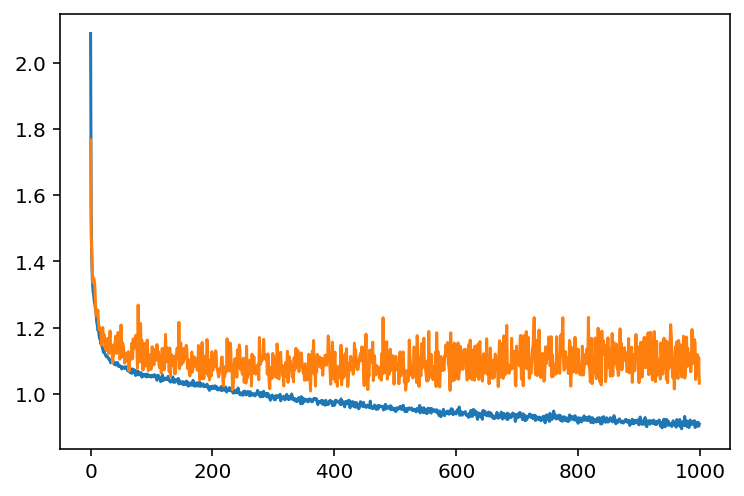

train_losses = 1000
val_losses = 1000


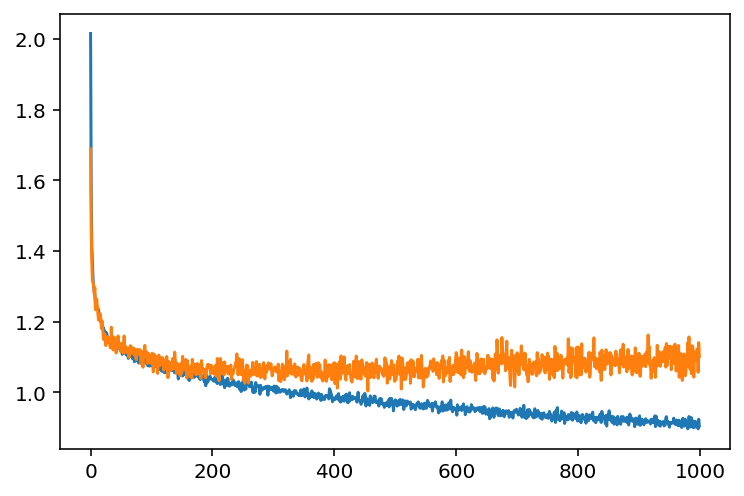

train_losses = 1000
val_losses = 1000


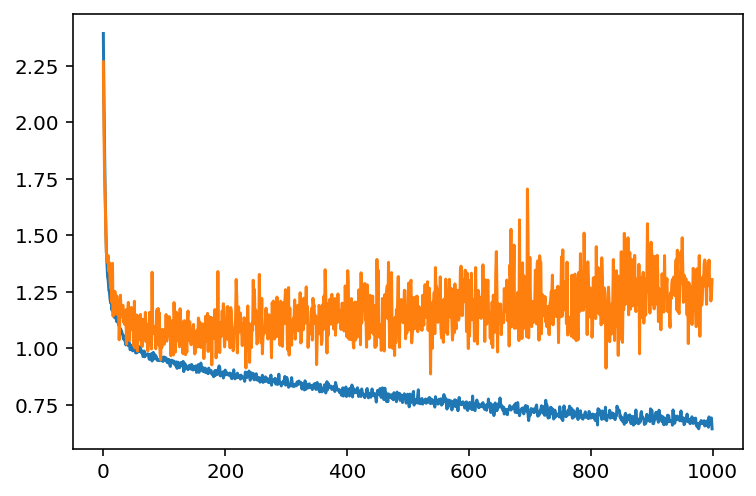

In [51]:
plot_model = WineQualityModel(build_generic_layers([85, 95, 105, 115, 115, 105, 95, 45]))
plot_model_white = WineQualityModel(build_generic_layers([85, 95, 105, 115, 115, 105, 95, 45]))
plot_model_red = WineQualityModel(build_generic_layers([85, 95, 105, 115, 115, 105, 95, 45]))

loaders = get_random_loaders(data_array, data_array_white, data_array_red)
criterion = torch.nn.CrossEntropyLoss()
criterion_white = torch.nn.CrossEntropyLoss()
criterion_red = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(plot_model.parameters(), lr=1e-3)
optimizer_white = torch.optim.Adam(plot_model_white.parameters(), lr=1e-3)
optimizer_red = torch.optim.Adam(plot_model_red.parameters(), lr=1e-3)

train_plot(plot_model, loaders[0][0], loaders[0][1], criterion, optimizer, 1000)
train_plot(plot_model_white, loaders[1][0], loaders[1][1], criterion_white, optimizer_white, 1000)
train_plot(plot_model_red, loaders[2][0], loaders[2][1], criterion_red, optimizer_red, 1000)

## Computational Experiment 3: MSE

In [76]:
def train_and_test_2(model, train_loader, val_loader, test_loader, criterion, optimizer, nepoch=1000, silent=True):
    
    try:
        cur_range = None
        if silent:
            cur_range = range(nepoch)
        else:
            cur_range = tqdm(range(nepoch))

        for epoch in cur_range:
            # Train over each epoch with a progress bar (tqdm)
            if not silent: 
                print('EPOCH %d'%epoch)
            
            total_loss = 0
            count = 0
            for inputs, labels in train_loader:
                # For each train input: 
                optimizer.zero_grad()
                labels = labels.float()

                # Forward propagate inputs
                outputs = model.forward(inputs)
                
                # Compute loss and learn
                loss = criterion(torch.squeeze(outputs), labels)
                
                loss.backward()
                optimizer.step()
                
                # Add current loss to batch average
                total_loss += loss.item()
                count += 1
            
            # Show Training loss for current epoch over the train_loader data
            if not silent:
                print('{:>12s} {:>7.5f}'.format('Train loss:', total_loss/count))
            
            with torch.no_grad():
                # Perform Validation checks on the newly trained model
                total_loss = 0
                count = 0
                for inputs, labels in val_loader:
                    # Forward propagate inputs
                    outputs = model.forward(inputs)
                    labels = labels.float()
                    
                    # Compute Loss
                    loss = criterion(torch.squeeze(outputs), labels)
                    # Add current loss to batch average
                    total_loss += loss.item()
                    count += 1
  
                # Show Validation loss for current epoch over the val_loader data
                if not silent:
                    print('{:>12s} {:>7.5f}'.format('Val loss:', total_loss/count))
                    print()
    except KeyboardInterrupt as e:
        print('Exiting from training early')
        raise e
    
    correct = 0
    total = 0
    true, pred = [], []
    with torch.no_grad():

        for inputs, labels  in test_loader:
            # Forward propagate testing data
            outputs = model.forward(inputs)
            labels = labels.float()
            # Get the prediction for inputs

            predicted = outputs

            # Tally results 
            total += labels.size(0)
            # correct += (predicted == labels).sum().item()
            correct_25 = (predicted)
            true.append(labels) 
            pred.append(predicted)

        # Compute and print final accuracy, then format outputs
        acc = (100 * correct / total)
        if not silent:
            print('%s accuracy: %0.3f' % (mode, acc))
        true = np.concatenate(true)
        pred = np.concatenate(pred)
    
    return acc, true, pred
    

In [73]:
# Computes the accuracy of a prediction list compared to a true list
# Measures two accuracies: exact accuracy, and tolerance 1 accuracy
#
# Inputs:
#     true: a list of actual labels
#     pred: a list of predicted labels
# Outputs:
#     exact_acc: percentage (in range (0,100)) of exact matches
#     t1_acc: percentage (range of (0,100)) of 1-tolerance matches
def compute_MSE_accuracies(true, pred):
    assert len(true) == len(pred)
    
    num_exact = 0
    num_1_tolerant = 0
    num_p5_tolerant = 0
    num_p25_tolerant = 0
    for i in range(len(true)):
        t = true[i]
        p = pred[i]
        
        if abs(t - p) <= 0.25:
            # Within one (e.g. 6,7,8 are all within 1 of 7)
            num_p25_tolerant += 1
        
        if abs(t - p) <= 0.5:
            # Within one (e.g. 6,7,8 are all within 1 of 7)
            num_p5_tolerant += 1

        if abs(t - p) <= 1:
            # Within one (e.g. 6,7,8 are all within 1 of 7)
            num_1_tolerant += 1
    
    tp25_acc = num_p25_tolerant / len(true) 
    tp5_acc = num_p5_tolerant / len(true)
    t1_acc = num_1_tolerant / len(true)
    return 100 * tp25_acc, 100 * tp5_acc, 100 * t1_acc

In [77]:
loaders = get_random_loaders(data_array, data_array_white, data_array_red)
criterion = torch.nn.MSELoss()
criterion_white = torch.nn.MSELoss()
criterion_red = torch.nn.MSELoss()


model = WineQualityModel(build_generic_layers([85, 95, 105, 115, 115, 105, 95, 45]) + (torch.nn.Linear(11, 1), ))
model_white = WineQualityModel(build_generic_layers([85, 95, 105, 115, 115, 105, 95, 45]) + (torch.nn.Linear(11, 1), ))
model_red = WineQualityModel(build_generic_layers([85, 95, 105, 115, 115, 105, 95, 45]) + (torch.nn.Linear(11, 1), ))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
optimizer_white = torch.optim.Adam(model_white.parameters(), lr=1e-3)
optimizer_red = torch.optim.Adam(model_red.parameters(), lr=1e-3)

acc, true, pred = train_and_test_2(model, *loaders[0], criterion, optimizer, nepoch=1000)
print(compute_MSE_accuracies(true, pred))

acc_white, true_white, pred_white = train_and_test_2(model_white, *loaders[1], criterion_white, optimizer_white, nepoch=1000)
print(compute_MSE_accuracies(true_white, pred_white))

acc_red, true_red, pred_red = train_and_test_2(model_red, *loaders[2], criterion_red, optimizer_red, nepoch=1000)
print(compute_MSE_accuracies(true_red, pred_red))


(27.769230769230766, 53.84615384615385, 84.46153846153847)
(26.122448979591837, 54.285714285714285, 85.3061224489796)
(28.4375, 57.1875, 88.125)


In [70]:
print(true)
print(pred)

[5. 5. 5. ... 4. 7. 5.]
[0 0 0 ... 0 0 0]
